# MERSCOPE Analysis

In [1]:
# Import necessary libraries
import scanpy as sc
import anndata as ad
import pandas as pd
import geopandas as gpd # For .parquet file with geometries
import matplotlib.pyplot as plt
import matplotlib.image as mpimg # For displaying images
import seaborn as sns
import numpy as np # For calculations if needed
import os
import squidpy
import warnings
import scipy.sparse

# Suppress FutureWarning messages
warnings.filterwarnings('ignore', category=FutureWarning)

/beegfs/scratch/ric.sessa/kubacki.michal/conda/envs/vpt/lib/python3.10/site-packages/anndata/utils.py:434: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/beegfs/scratch/ric.sessa/kubacki.michal/conda/envs/vpt/lib/python3.10/site-packages/anndata/utils.py:434: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)
/beegfs/scratch/ric.sessa/kubacki.michal/conda/envs/vpt/lib/python3.10/site-packages/anndata/utils.py:434: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/beegfs/scratch/ric.sessa/kubacki.michal/conda/envs/vpt/lib/python3.10/site-packages/anndata/utils.py:434: FutureWarning: Importing read_mtx from `anndata` is deprecated. Import anndata.io.read_mtx instead.
  warnings.warn(msg, FutureWarning)
/beegfs/scratch/ric.se

In [2]:
os.chdir("/beegfs/scratch/ric.sessa/kubacki.michal/SRF_Linda/SRF_Spatial_segmentation")

# Define file paths
base_path = 'DATA/p30-E165/R4'
h5ad_file = os.path.join(base_path, 'data.h5ad')
summary_image_file = os.path.join(base_path, 'summary.png') 

## 1. Data Loading

In [3]:
# Attempt to load the .h5ad file
adata = None
try:
    adata = sc.read_h5ad(h5ad_file)
    print(f"Successfully loaded AnnData file: {h5ad_file}")
    print(adata)
except FileNotFoundError:
    print(f"AnnData file not found: {h5ad_file}. Will attempt to load individual files.")
except Exception as e:
    print(f"Error loading AnnData file {h5ad_file}: {e}. Will attempt to load individual files.")

Successfully loaded AnnData file: DATA/p30-E165/R4/data.h5ad
AnnData object with n_obs × n_vars = 22613 × 960
    obs: 'volume', 'center_x', 'center_y', 'n_counts', 'n_genes', 'leiden'
    var: 'mean', 'std'
    uns: 'leiden', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'


In [4]:
print(adata.obs.index[:5])
print(adata.obs.volume.head())
print(adata.obs.center_x.head())
print(adata.obs.leiden.head())

Index(['1678497000000100030', '1678497000000100031', '1678497000000100032',
       '1678497000000100033', '1678497000000100035'],
      dtype='object', name='cell')
cell
1678497000000100030    2551.229934
1678497000000100031    1164.514849
1678497000000100032    1604.968082
1678497000000100033    2182.728229
1678497000000100035    1042.151256
Name: volume, dtype: float64
cell
1678497000000100030     9870.501629
1678497000000100031    10003.782457
1678497000000100032    10055.359602
1678497000000100033    10122.192315
1678497000000100035     9955.601503
Name: center_x, dtype: float64
cell
1678497000000100030    1
1678497000000100031    1
1678497000000100032    1
1678497000000100033    7
1678497000000100035    6
Name: leiden, dtype: category
Categories (25, object): ['0', '1', '2', '3', ..., '21', '22', '23', '24']


In [5]:
keep_genes = [x for x in adata.var.index.tolist() if 'Blank' not in x]
print(len(keep_genes))
print(adata.shape[1])

960
960


In [6]:
min_expression = 25
ser_exp = adata.to_df().sum(axis=1)

keep_cells = ser_exp[ser_exp > min_expression].index.tolist()
print(len(keep_cells))
print(adata.shape[0])

# adata = adata[keep_cells]
# adata

22610
22613


In [7]:
adata_v2 = adata.copy()

# 1b Supplementary files (not essential)

## Count data

In [8]:
cell_by_gene_file = os.path.join(base_path, 'cell_by_gene.csv')

In [9]:
# Load gene expression data
counts_df = pd.read_csv(cell_by_gene_file, index_col=0) # Assuming first column is cell ID
print(f"Loaded {cell_by_gene_file}: {counts_df.shape[0]} cells, {counts_df.shape[1]} genes")
non_zero_values = counts_df.values[counts_df.values != 0]
top_5_values = sorted(non_zero_values, reverse=True)[:5]
print("Top 5 non-zero values:", top_5_values)

Loaded DATA/p30-E165/R4/cell_by_gene.csv: 22872 cells, 1000 genes
Top 5 non-zero values: [1111, 1095, 1060, 1011, 991]


## Metadata

In [10]:
cell_metadata_file = os.path.join(base_path, 'cell_metadata.csv')

In [11]:
# Load cell metadata
metadata_df = pd.read_csv(cell_metadata_file, index_col=0) # Assuming first column is cell ID
print(f"Loaded {cell_metadata_file}: {metadata_df.shape[0]} cells, {metadata_df.shape[1]} metadata columns")
metadata_df.head()

Loaded DATA/p30-E165/R4/cell_metadata.csv: 22872 cells, 28 metadata columns


,fov,volume,center_x,center_y,min_x,min_y,max_x,max_y,anisotropy,transcript_count,...,DAPI_raw,DAPI_high_pass,Ttr_raw,Ttr_high_pass,Pcp4_raw,Pcp4_high_pass,hSETBP1_raw,hSETBP1_high_pass,PolyT_raw,PolyT_high_pass
EntityID,,,,,,,,,,,,,,,,,,,,,
1678497000000100030,3,2551.229934,9870.501629,11.848953,9860.672354,3.355088,9879.696009,20.619845,1.146750,44,...,129201696.0,2.737316e+06,402001490.0,2.849728e+06,361499788.0,6.481458e+06,131032249.0,1.468332e+06,699649548.0,7.414356e+06
1678497000000100031,3,1164.514849,10003.782457,10.550269,9996.600940,4.538589,10012.501108,15.869512,1.572390,31,...,62081564.0,1.273673e+06,206156451.0,1.558795e+06,177260433.0,3.338922e+06,64235034.0,7.108177e+05,298826412.0,3.307413e+06
1678497000000100032,14,1604.968082,10055.359602,12.110075,10048.167118,4.699752,10062.368422,20.449123,1.106067,38,...,56165580.0,9.671331e+05,205325308.0,1.965740e+06,156698563.0,3.016192e+06,70164259.0,9.636369e+05,271397558.0,3.192166e+06
1678497000000100033,14,2182.728229,10122.192315,7.702009,10109.551640,1.104019,10133.618933,15.525474,2.248713,74,...,379061393.0,4.980442e+06,289509259.0,3.140393e+06,164736563.0,3.838000e+06,101277471.0,1.619673e+06,686873493.0,5.809776e+06
1678497000000100035,3,1042.151256,9955.601503,11.990010,9949.516114,5.971764,9961.484294,17.793373,1.547717,82,...,76039334.0,1.478414e+06,171836974.0,1.241520e+06,221655600.0,5.242650e+06,55410997.0,6.566117e+05,287450762.0,2.547780e+06


In [12]:
# Align indices (important!)
common_cells = counts_df.index.intersection(metadata_df.index)
counts_df = counts_df.loc[common_cells]
metadata_df = metadata_df.loc[common_cells]
print(f"Found {len(common_cells)} common cells between counts and metadata.")

if len(common_cells) == 0:
    raise ValueError("No common cells found between cell_by_gene.csv and cell_metadata.csv. Cannot create AnnData object.")

Found 22872 common cells between counts and metadata.


In [13]:
# Create AnnData object
# adata = ad.AnnData(X=counts_df.values, obs=metadata_df, var=pd.DataFrame(index=counts_df.columns))
# adata.X = adata.X.astype('float32') # Ensure X is float for scanpy operations
# print("Successfully created AnnData object from CSV files.")
# print(adata)

### Cell boundaries

In [14]:
cell_boundaries_file = os.path.join(base_path, 'cell_boundaries.parquet')
cell_boundaries_gdf = None

In [15]:
cell_boundaries_gdf = gpd.read_parquet(cell_boundaries_file)
print(f"Loaded {cell_boundaries_file}. Shape: {cell_boundaries_gdf.shape}")

Loaded DATA/p30-E165/R4/cell_boundaries.parquet. Shape: (160104, 9)


In [16]:
cell_boundaries_gdf.head()

,ID,EntityID,ZIndex,Geometry,ParentType,ParentID,Type,ZLevel,Name
1,1,1678497000000100030,3,"MULTIPOLYGON (((9860.672 10.657, 9862.142 14.7...",None,None,cell,6.0,None
2,2,1678497000000100031,3,"MULTIPOLYGON (((9996.601 8.571, 9998.482 12.51...",None,None,cell,6.0,None
3,3,1678497000000100032,3,"MULTIPOLYGON (((10048.181 10.141, 10048.167 11...",None,None,cell,6.0,None
4,4,1678497000000100033,3,"MULTIPOLYGON (((10115.294 8.797, 10116.661 10....",None,None,cell,6.0,None
6,6,1678497000000100035,3,"MULTIPOLYGON (((9950.167 16.497, 9951.921 17.7...",None,None,cell,6.0,None


In [17]:
cell_boundaries_gdf = cell_boundaries_gdf.set_index('EntityID', drop=False)
cell_boundaries_gdf.head()

,ID,EntityID,ZIndex,Geometry,ParentType,ParentID,Type,ZLevel,Name
EntityID,,,,,,,,,
1678497000000100030,1,1678497000000100030,3,"MULTIPOLYGON (((9860.672 10.657, 9862.142 14.7...",None,None,cell,6.0,None
1678497000000100031,2,1678497000000100031,3,"MULTIPOLYGON (((9996.601 8.571, 9998.482 12.51...",None,None,cell,6.0,None
1678497000000100032,3,1678497000000100032,3,"MULTIPOLYGON (((10048.181 10.141, 10048.167 11...",None,None,cell,6.0,None
1678497000000100033,4,1678497000000100033,3,"MULTIPOLYGON (((10115.294 8.797, 10116.661 10....",None,None,cell,6.0,None
1678497000000100035,6,1678497000000100035,3,"MULTIPOLYGON (((9950.167 16.497, 9951.921 17.7...",None,None,cell,6.0,None


In [18]:
# adata.obs.index = adata.obs.index.astype(str)
# cell_boundaries_gdf.index = cell_boundaries_gdf.index.astype(str)

# print(adata.obs.index[:5])
# print(cell_boundaries_gdf.index[:5])

In [19]:
# common_cells_boundaries = adata.obs.index.intersection(cell_boundaries_gdf.index)
# common_cells_boundaries[:5]

In [20]:
# adata.uns['cell_boundaries_gdf'] = cell_boundaries_gdf.loc[common_cells_boundaries]

## Differentially expressed genes

In [21]:
differentially_expressed_genes_file = os.path.join(base_path, 'differentially_expressed_genes.csv')

In [22]:
degs_df = pd.read_csv(differentially_expressed_genes_file, index_col=0)
print(degs_df.shape)
print(adata.shape)

(24000, 5)
(22613, 960)


In [23]:
degs_df.head()

,gene,cluster_id,p_value,fold_change,adjusted_p_value
323,Abl1,0,1.381203e-04,0.443436,2.441906e-04
693,Ablim1,0,3.795704e-02,-0.147193,5.161298e-02
686,Acsl1,0,8.479296e-02,-0.154535,1.107500e-01
819,Acta2,0,1.508772e-14,-1.626880,4.323644e-14
34,Adcy1,0,3.409047e-121,0.973278,5.546924e-120


In [24]:
print(len(degs_df.gene.unique()))

960


In [25]:
degs_df = degs_df.set_index('gene', drop=False)
degs_df.shape

(24000, 5)

In [26]:
print(degs_df.index[:5])
print(adata.var.index[:5])

Index(['Abl1', 'Ablim1', 'Acsl1', 'Acta2', 'Adcy1'], dtype='object', name='gene')
Index(['Gnai3', 'Ngfr', 'Wnt3', 'Ccnd2', 'Lhx2'], dtype='object')


In [27]:
adata.var.index = adata.var.index.astype(str)
degs_df.index = degs_df.index.astype(str)

In [28]:
common_genes = adata.var.index.intersection(degs_df.index)
len(common_genes)

960

In [29]:
# adata.uns['cell_boundaries_gdf'] = degs_df.loc[common_genes]

## Detected transcripts

In [30]:
detected_transcripts_file = os.path.join(base_path, 'detected_transcripts.parquet')

In [31]:
det_trans_df = pd.read_parquet(detected_transcripts_file)
det_trans_df.shape

(16252852, 11)

In [32]:
det_trans_df.head()

,,barcode_id,global_x,global_y,global_z,x,y,fov,gene,transcript_id,cell_id
0,35,17,9795.153320,421.919830,0.0,1553.231689,183.702347,0,Efnb2,ENSMUST00000001319,-1
1,206,222,9645.224609,467.659363,0.0,165.000000,607.216553,0,Gabra4,ENSMUST00000031121,-1
2,362,222,9717.008789,511.821411,0.0,829.668396,1016.124268,0,Gabra4,ENSMUST00000031121,-1
3,413,222,9811.153320,525.416016,0.0,1701.382080,1142.000000,0,Gabra4,ENSMUST00000031121,-1
4,462,222,9758.066406,539.323486,0.0,1209.830444,1270.773193,0,Gabra4,ENSMUST00000031121,-1


## Cell categories

In [33]:
cell_categories_file = os.path.join(base_path, 'cell_categories.csv')
cell_numeric_categories_file = os.path.join(base_path, 'cell_numeric_categories.csv')

In [34]:
cell_categories_df = pd.read_csv(cell_categories_file, index_col=0) # Assuming first column is cell ID
cell_numeric_categories_df = pd.read_csv(cell_numeric_categories_file, index_col=0) # Assuming first column is cell ID

In [35]:
cell_categories_df.head()

,leiden
EntityID,
1678497000000100030,1
1678497000000100031,1
1678497000000100032,1
1678497000000100033,7
1678497000000100035,6


In [36]:
cell_numeric_categories_df.head()

,umap_X,umap_Y
EntityID,,
1678497000000100030,10.198257,1.319038
1678497000000100031,8.245227,1.027782
1678497000000100032,9.211431,2.082012
1678497000000100033,5.073660,5.072837
1678497000000100035,15.609959,-16.069569


# 2. Exploratory Data Analysis

Basic statistics and distributions of the data.

In [37]:
print(f"Number of cells: {adata.n_obs}")
print(f"Number of genes: {adata.n_vars}")

Number of cells: 22613
Number of genes: 960


In [38]:
print("Calculating QC metrics (total_counts, n_genes_by_counts)...")
sc.pp.calculate_qc_metrics(adata, inplace=True)

Calculating QC metrics (total_counts, n_genes_by_counts)...


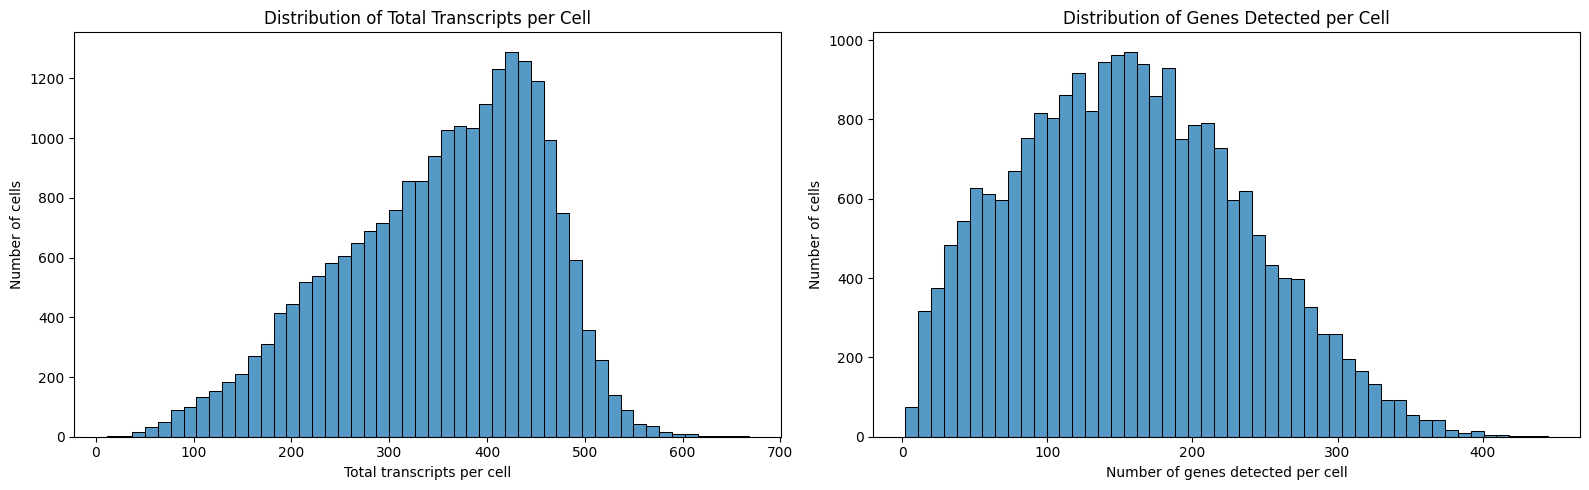

In [39]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Plot for total_counts
sns.histplot(adata.obs['total_counts'], bins=50, kde=False, ax=axes[0])
axes[0].set_xlabel("Total transcripts per cell")
axes[0].set_ylabel("Number of cells")
axes[0].set_title("Distribution of Total Transcripts per Cell")

# Plot for n_genes_by_counts
sns.histplot(adata.obs['n_genes_by_counts'], bins=50, kde=False, ax=axes[1])
axes[1].set_xlabel("Number of genes detected per cell")
axes[1].set_ylabel("Number of cells")
axes[1].set_title("Distribution of Genes Detected per Cell")

plt.tight_layout()
plt.show()

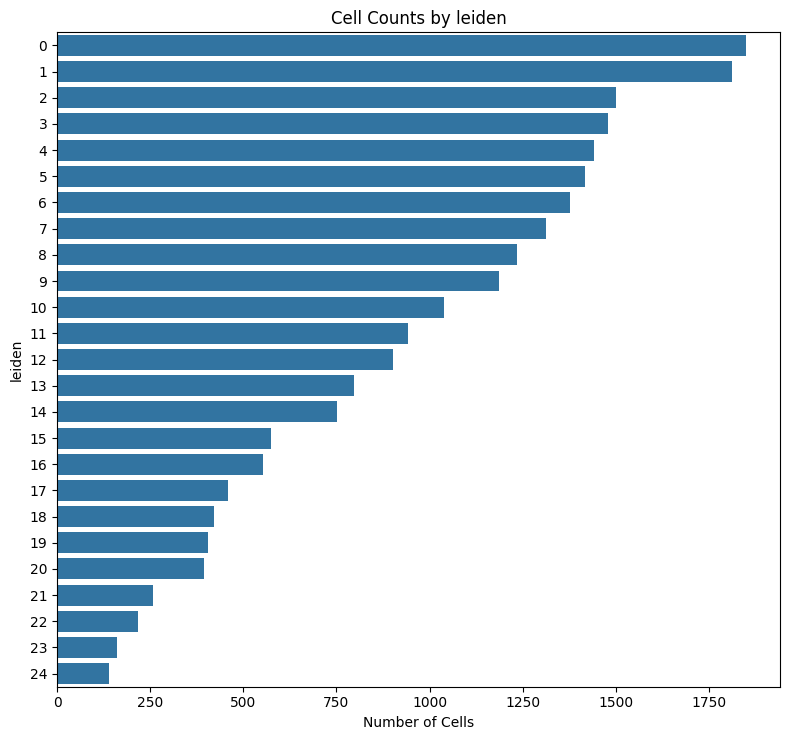

In [40]:
coll_to_summary = 'leiden'

if adata.obs[coll_to_summary].nunique() < 30 and adata.obs[coll_to_summary].nunique() > 1:
    plt.figure(figsize=(8, max(4, adata.obs[coll_to_summary].nunique() * 0.3)))
    sns.countplot(y=adata.obs[coll_to_summary], order = adata.obs[coll_to_summary].value_counts(dropna=False).index)
    plt.title(f"Cell Counts by {coll_to_summary}")
    plt.xlabel("Number of Cells")
    plt.ylabel(coll_to_summary)
    plt.tight_layout()
    plt.show()

## 3. Visualization

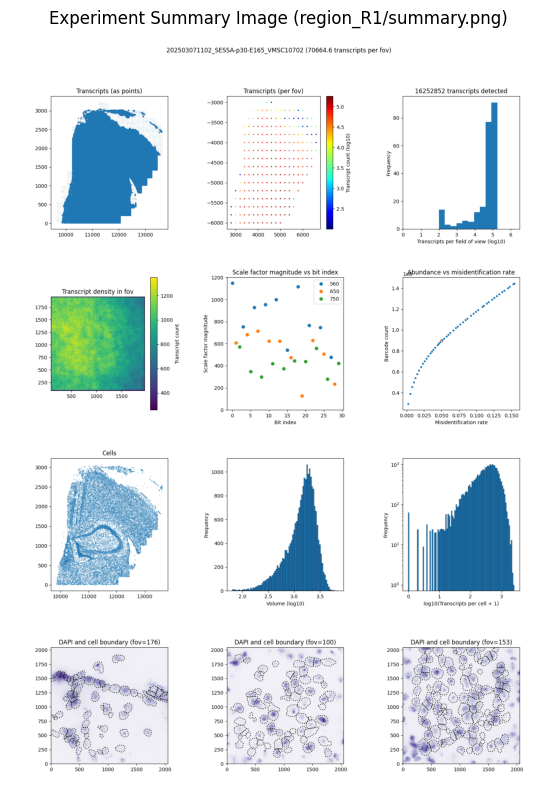

In [41]:
img = mpimg.imread(summary_image_file)
plt.figure(figsize=(10,10))
plt.imshow(img)
plt.axis('off') # Turn off axis numbers and ticks
plt.title("Experiment Summary Image (region_R1/summary.png)")
plt.show()

In [42]:
print(adata.obsm_keys())
print(list(adata.obs.columns))

['X_pca', 'X_umap']
['volume', 'center_x', 'center_y', 'n_counts', 'n_genes', 'leiden', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes']


In [43]:
adata.obsm['spatial'] = adata.obs[['center_x', 'center_y']].to_numpy()
spatial_coords_available = True

<Figure size 1000x1000 with 0 Axes>

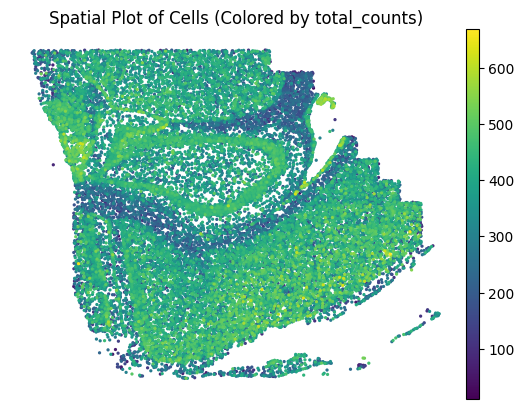

<Figure size 1000x1000 with 0 Axes>

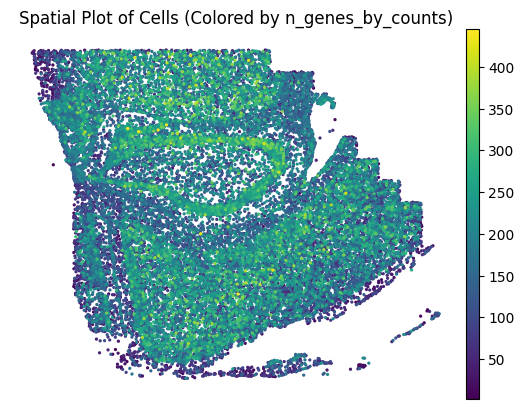

<Figure size 1000x1000 with 0 Axes>

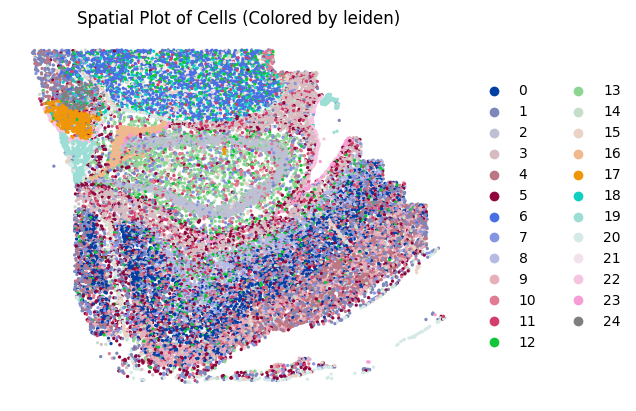

In [44]:
features = ['total_counts', 'n_genes_by_counts', 'leiden']
for color_by in features:
    plt.figure(figsize=(10, 10))
    sc.pl.spatial(adata, color=color_by, spot_size=30, show=False, frameon=False)
    plt.title(f"Spatial Plot of Cells (Colored by {color_by if color_by else 'default'})")
    plt.show()

In [45]:
print(list(adata.var.columns))
print(list(adata.uns))

['mean', 'std', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts']
['leiden', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'umap', 'leiden_colors']


In [46]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5, flavor='cell_ranger')

In [47]:
print(f"adata.X data type: {adata.X.dtype}")

if scipy.sparse.issparse(adata.X):
    print(adata.X[:5, :5].toarray())
    if adata.X.nnz > 0: # nnz is number of stored_elements
        print(f"Min non-zero value in adata.X: {adata.X.data.min()}")
        print(f"Max non-zero value in adata.X: {adata.X.data.max()}")
        has_nan_sparse = np.isnan(adata.X.data).any()
        has_inf_sparse = np.isinf(adata.X.data).any()
        print(f"adata.X.data contains NaNs: {has_nan_sparse}")
        print(f"adata.X.data contains Infs: {has_inf_sparse}")

else: # Dense array
    print(adata.X[:5, :5])
    print(f"Min value in adata.X: {adata.X.min()}")
    print(f"Max value in adata.X: {adata.X.max()}")
    has_nan_dense = np.isnan(adata.X).any()
    has_inf_dense = np.isinf(adata.X).any()
    print(f"adata.X contains NaNs: {has_nan_dense}")
    print(f"adata.X contains Infs: {has_inf_dense}")

adata.X data type: float32
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
Min value in adata.X: 0.0
Max value in adata.X: 50.36949920654297
adata.X contains NaNs: False
adata.X contains Infs: False


Plotting spatial expression for HVGs: ['Gnai3', 'Wnt3', 'Plin2']


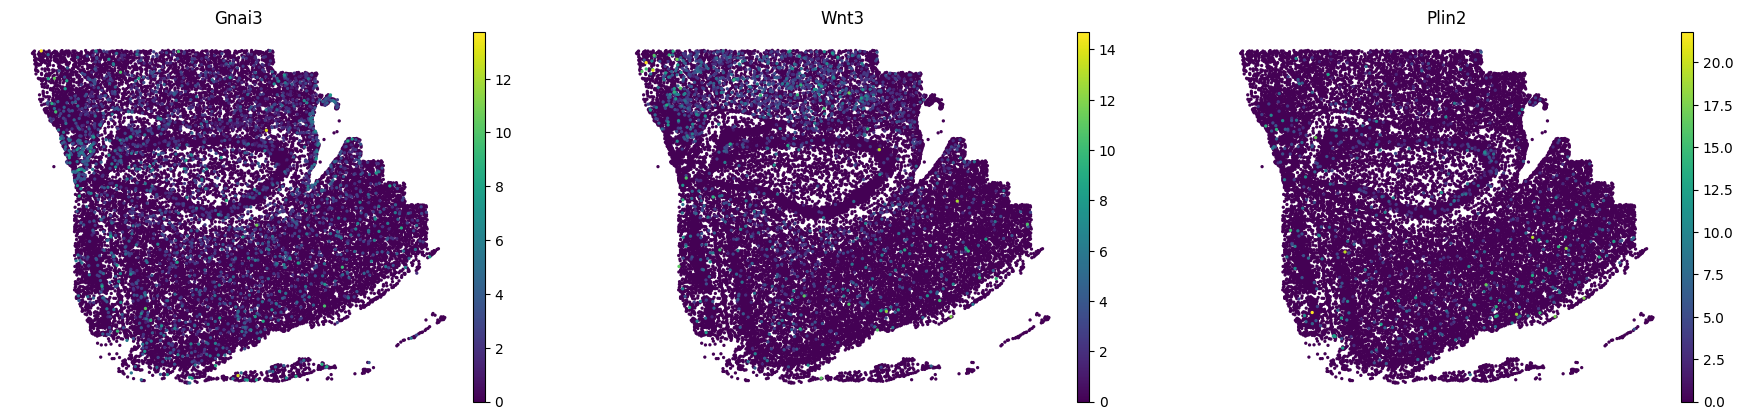

In [48]:
hvg_genes = adata.var_names[adata.var['highly_variable']].tolist()
if len(hvg_genes) > 0:
    num_genes_to_plot = min(len(hvg_genes), 3)
    genes_to_plot = hvg_genes[:num_genes_to_plot]
    print(f"Plotting spatial expression for HVGs: {genes_to_plot}")
    sc.pl.spatial(adata, color=genes_to_plot, spot_size=30, show=True, frameon=False, ncols=num_genes_to_plot)
else:
    print("No highly variable genes found after computation.")



/beegfs/scratch/ric.sessa/kubacki.michal/conda/envs/vpt/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


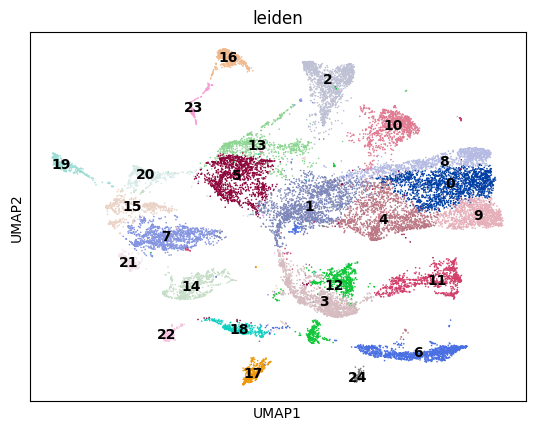

In [49]:
# generate colors for categories by plotting
sc.pl.umap(adata, color="leiden", legend_loc='on data')

# 3. Alternative DEGs

In [50]:
resolution = 1.5

sc.pp.normalize_total(adata_v2)
sc.pp.log1p(adata_v2)
sc.pp.scale(adata_v2, max_value=10)
sc.tl.pca(adata_v2, svd_solver='arpack')
sc.pp.neighbors(adata_v2, n_neighbors=10, n_pcs=20)
sc.tl.umap(adata_v2)
sc.tl.leiden(adata_v2, resolution=resolution)

/beegfs/scratch/ric.sessa/kubacki.michal/conda/envs/vpt/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


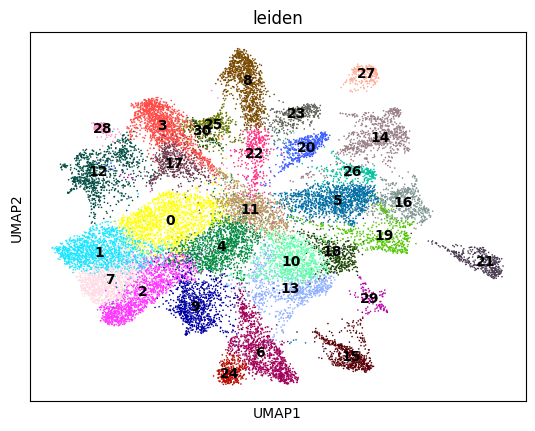

In [51]:
sc.pl.umap(adata_v2, color="leiden", legend_loc='on data')

# R. ROI

In [52]:
roi_file = os.path.join(base_path, "cells1.csv")
roi_data = pd.read_csv(roi_file)
cell1_ids = roi_data.iloc[:, 0].astype(str).tolist()
cell1_ids[:5]

['1678497000009100626',
 '1678497000009101297',
 '1678497000009200589',
 '1678497000010100510',
 '1678497000010100549']

In [53]:
roi_file = os.path.join(base_path, "cells2.csv")
roi_data = pd.read_csv(roi_file)
cell2_ids = roi_data.iloc[:, 0].astype(str).tolist()
cell2_ids[:5]

['1678497000009100454',
 '1678497000009100456',
 '1678497000009100499',
 '1678497000009100533',
 '1678497000009100546']

In [54]:
# roi1 = adata[adata.obs.index.isin(cell2_ids[:5]
# ), :]
# roi1

In [55]:
# adata[adata.obs.index.isin(cell_ids), :].obs["roi"] = "roi1"

In [56]:
# For multiple ROI assignments
roi_assignments = {
    "roi1": cell1_ids,
    "roi2": cell2_ids
}

# Initialize column
adata_v2.obs["roi"] = "unassigned"

# Assign each ROI
for roi_name, cell_list in roi_assignments.items():
    mask = adata_v2.obs.index.isin(cell_list)
    adata_v2.obs.loc[mask, "roi"] = roi_name

<Figure size 1000x1000 with 0 Axes>

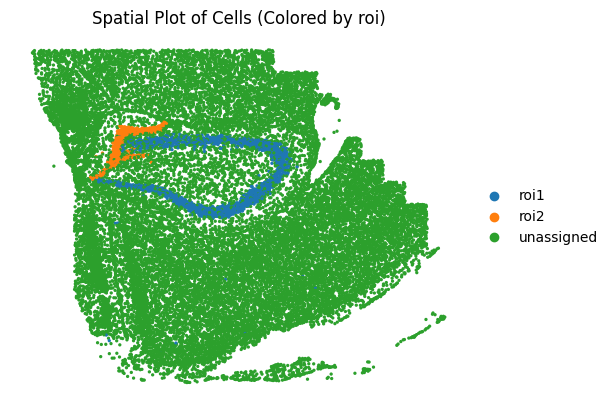

In [57]:
adata_v2.obsm['spatial'] = adata_v2.obs[['center_x', 'center_y']].to_numpy()
color_by = "roi"
plt.figure(figsize=(10, 10))
sc.pl.spatial(adata_v2, color=color_by, spot_size=30, show=False, frameon=False)
plt.title(f"Spatial Plot of Cells (Colored by {color_by if color_by else 'default'})")
plt.show()

/beegfs/scratch/ric.sessa/kubacki.michal/conda/envs/vpt/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


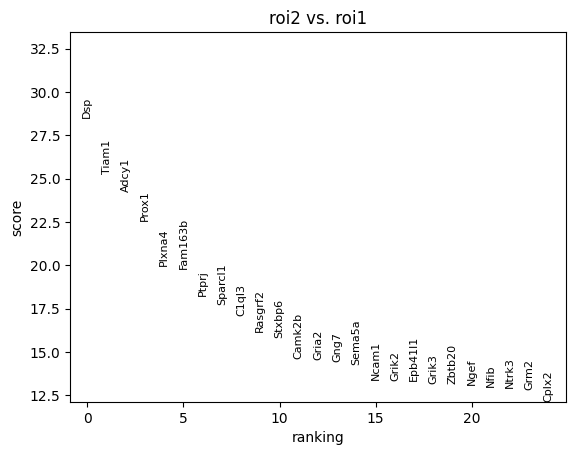

      names     scores  logfoldchanges          pvals      pvals_adj
0       Dsp  28.531996             NaN  4.698635e-179  4.510690e-176
1     Tiam1  25.250317             NaN  1.123519e-140  2.696446e-138
2     Adcy1  24.210752        5.965784  1.714129e-129  2.742607e-127
3     Prox1  22.560173             NaN  1.067054e-112  1.463389e-110
4    Plxna4  19.938423        2.067468   1.889277e-88   1.648823e-86
5   Fam163b  19.818302             NaN   2.069749e-87   1.655799e-85
6     Ptprj  18.236536        2.712364   2.647117e-74   1.694155e-72
7   Sparcl1  17.694166       -1.548157   4.650660e-70   2.480352e-68
8     C1ql3  17.052919             NaN   3.325023e-65   1.520010e-63
9   Rasgrf2  16.177561             NaN   7.261395e-59   2.788376e-57
10   Stxbp6  15.797760             NaN   3.223716e-56   1.146210e-54
11   Camk2b  14.612254        0.661665   2.346262e-48   7.766937e-47
12    Gria2  14.557001        0.958926   5.272067e-48   1.687062e-46
13     Gng7  14.403502        5.81

In [58]:
# First, subset to only cells in roi1 and roi2 (exclude unassigned)
adata_roi = adata_v2[adata_v2.obs["roi"].isin(["roi1", "roi2"])].copy()

# Run differential expression analysis
sc.tl.rank_genes_groups(
    adata_roi, 
    groupby='roi',  # Column containing your groups
    method='wilcoxon',  # or 't-test', 'logreg', 't-test_overestim_var'
    key_added='roi_deg',  # Key to store results
    reference='roi1',  # Compare roi2 vs roi1 (or use 'rest' for one-vs-rest)
    n_genes=None # Calculate for all genes
)

# View top DEGs
sc.pl.rank_genes_groups(adata_roi, key='roi_deg', n_genes=25, sharey=False)

# Get results as a DataFrame
# Top genes upregulated in roi2 compared to roi1
result = sc.get.rank_genes_groups_df(adata_roi, group='roi2', key='roi_deg')
print(result.head(20))

# Save full results
result.to_csv('roi2_vs_roi1_DEGs.csv', index=False)

# Filter by significance and fold change
significant_degs = result[
    (result['pvals_adj'] < 0.05) &  # Adjusted p-value threshold
    (abs(result['logfoldchanges']) > 0.5)  # Log fold change threshold
]
print(f"Number of significant DEGs: {len(significant_degs)}")